In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


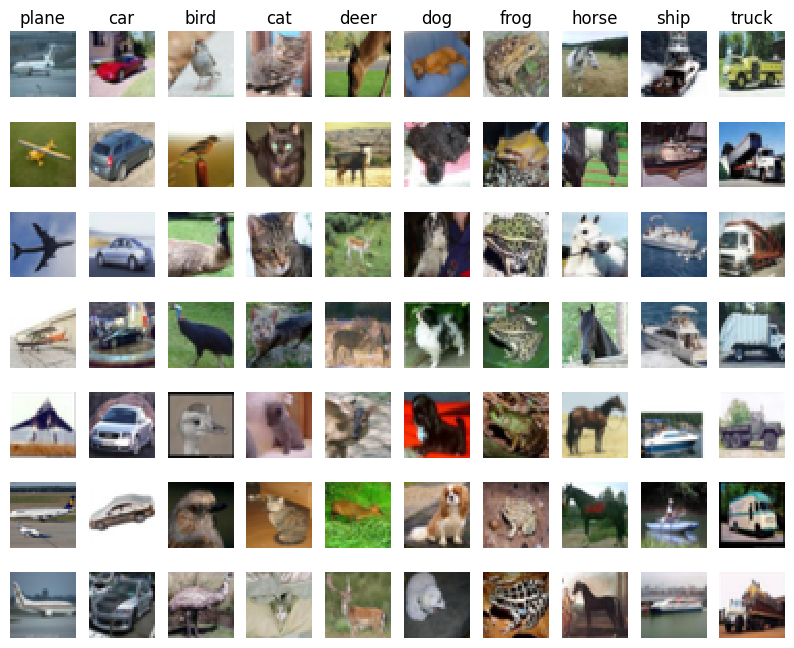

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


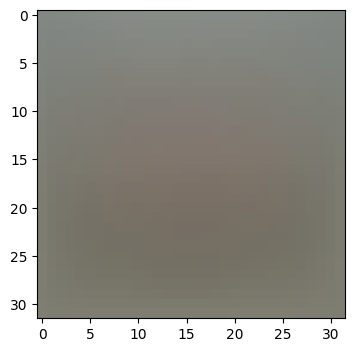

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.604265


In [9]:
#여기는 위 셀의 정답 코드입니다.
# def svm_loss_naive(W, X, y, reg):
#     """
#     Structured SVM loss function, naive implementation (with loops).

#     Inputs have dimension D, there are C classes, and we operate on minibatches
#     of N examples.

#     Inputs:
#     - W: A numpy array of shape (D, C) containing weights.
#     - X: A numpy array of shape (N, D) containing a minibatch of data.
#     - y: A numpy array of shape (N,) containing training labels; y[i] = c means
#       that X[i] has label c, where 0 <= c < C.
#     - reg: (float) regularization strength

#     Returns a tuple of:
#     - loss as single float
#     - gradient with respect to weights W; an array of same shape as W
#     """
#     dW = np.zeros(W.shape)  # initialize the gradient as zero

#     # compute the loss and the gradient
#     num_classes = W.shape[1]
#     num_train = X.shape[0]
#     loss = 0.0
#     for i in range(num_train):
#         scores = X[i].dot(W)
#         correct_class_score = scores[y[i]]
#         for j in range(num_classes):
#             if j == y[i]:
#                 continue
#             margin = scores[j] - correct_class_score + 1  # note delta = 1
#             if margin > 0: #계산한 loss값이 0보다 크다면..
#                 loss += margin
#                 dW[:, y[i]] -= X[i] #loss 함수를 y에 대해서 편미분
#                 dW[:, j] += X[i]  #loss함수를 x에 대해서 편미분

#     # Right now the loss is a sum over all training examples, but we want it
#     # to be an average instead so we divide by num_train.
#     loss /= num_train
#     dW /= num_train

#     # Add regularization to the loss.
#     loss += reg * np.sum(W * W)
#     dW += reg * 2 * W

#     #############################################################################
#     # TODO:                                                                     #
#     # Compute the gradient of the loss function and store it dW.                #
#     # Rather that first computing the loss and then computing the derivative,   #
#     # it may be simpler to compute the derivative at the same time that the     #
#     # loss is being computed. As a result you may need to modify some of the    #
#     # code above to compute the gradient.                                       #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.463760 analytic: 4.463760, relative error: 8.685257e-11
numerical: -13.710718 analytic: -13.685824, relative error: 9.086472e-04
numerical: -13.144102 analytic: -13.166430, relative error: 8.486417e-04
numerical: 18.877881 analytic: 18.848833, relative error: 7.699469e-04
numerical: -0.454080 analytic: -0.478864, relative error: 2.656535e-02
numerical: -9.137730 analytic: -9.222946, relative error: 4.641203e-03
numerical: 13.629236 analytic: 13.629236, relative error: 9.488532e-12
numerical: 7.272532 analytic: 7.257828, relative error: 1.011917e-03
numerical: 12.806496 analytic: 12.806496, relative error: 4.911493e-12
numerical: -6.188966 analytic: -6.145415, relative error: 3.530838e-03
numerical: 10.754483 analytic: 10.754483, relative error: 2.769400e-11
numerical: -3.715983 analytic: -3.715983, relative error: 7.589150e-11
numerical: -15.615056 analytic: -15.637096, relative error: 7.052227e-04
numerical: 4.449626 analytic: 4.449626, relative error: 3.522592e-11
numeri

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$

**What could such a discrepancy be caused by?**

이는 Numerical Gradient를 계산할 경우에 사용되는 h를 우극한 값으로 정의하는 것에서 기인한다. L = max(0,C)인데, 우극한 값으로 정의되는 numerical gradient를 사용할 경우 C의 값은 아주 작은 양수가 될 것이고 그렇다면 0의 값이 아니라 양수의 값이 L로 선택되어질 것이다.

그러나 Analytical Gradient의 경우 단순하게 공식에 맞추어 계산한다(x=0 : 미분불가능, x>0 : 기울기 0, x < 0 : 기울기 -1). 따라서 둘의 값에는 차이가 존재한다.

**Is it a reason for concern?**

이는 크게 걱정할 만한 일이 아니다. Hinge Loss 함수의 특성을 고려하게 되면 일정 Margin을 넘으면 성능의 개선에는 관심이 없다. 즉 일정 임계를 넘게 되면 모두 같은 값으로 분류한다는 의미이다.

**What is a simple example in one dimension where a gradient check could fail?**
미분 가능하지 않은 것의 특징은 1)뾰족점, 2) 불연속점인데, Hinge Loss 함수의 특성상 일정 임계(마진)을 넘어서는 순간 0에 수렴하게 된다. 해당하는 지점은 그래프의 급격한 변화로 인해 불연속 점이기 때문에 미분 불가능한 지점이 된다. 따라서 해당 지점은 그라디언트 체크가 불가능한 지점이 될 것이다.

**How would change the margin affect of the frequency of this happening?**

마진을 크게 증가시키면 힌지 부분이 우측으로 이동한다는 것을 의미한다. 이는 정답의 스코어가 '예측값 + Margin값'이 아닌 이상 힌지 부분의 값을 만날 수 없다는 말이다. 따라서 analytical과 numerical의 차이를 줄일 수 있을 것이다.



In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.604265e+00 computed in 0.100410s
Vectorized loss: 0.000000e+00 computed in 0.000481s
difference: 8.604265


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.101277s
Vectorized loss and gradient: computed in 0.013707s
difference: 0.000000


In [ ]:
# def svm_loss_vectorized(W, X, y, reg):
#     """
#     Structured SVM loss function, vectorized implementation.

#     Inputs and outputs are the same as svm_loss_naive.
#     """
#     loss = 0.0
#     dW = np.zeros(W.shape)  # initialize the gradient as zero

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the structured SVM loss, storing the    #
#     # result in loss.                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     #1) 데이터의 클래스 개수정의하기
#     num_classes = W.shape[1]
#     #2)데이터의 인스턴스 개수 정의하기
#     num_train = X.shape[0]
#     #scores는 X*W -> X는 (N,D) W는 (D,C)
#     scores = X.dot(W)
#     #train을 순차로 나열하고, scores행렬에서 정답 클래스의 값을 추출
#     correct_class_score = scores[np.arange(num_train), y]
#     #로스(마진)값을 계산
#     margins = np.maximum(0, scores - correct_class_score[:, np.newaxis] + 1)
#     #정답클래스의 마진(로스)은 0
#     margins[np.arange(num_train), y] = 0
#     loss = np.sum(margins)
#     loss /= num_train
#     loss += reg * np.sum(W * W)


#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the gradient for the structured SVM     #
#     # loss, storing the result in dW.                                           #
#     #                                                                           #
#     # Hint: Instead of computing the gradient from scratch, it may be easier    #
#     # to reuse some of the intermediate values that you used to compute the     #
#     # loss.                                                                     #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     #margins의 shape을 카피해 놓고 -> 나중에 그라디언트 계산할 때 활용
#     #손실이 있는..(잘못 예측한) 클래스에는 1을 할당하여 정답 예측한 부분과 분리
#     X_mask = np.zeros(margins.shape)
#     X_mask[margins > 0] = 1
#     #잘못 예측했으면 열의 값이 1일 것이다. 이 1들을 모두 sum하여 개수를 산정하면 -> 잘못분류한 데이터의 개수이다.
#     incorrect_counts = np.sum(X_mask, axis=1)
#     # 정답클래스에 잘못 분류한 개수만큼 -를 줌으로서 zero-sum으로 만들어줌 -> 학습할 때..정답 클래스 값이 더 커지니깐..오류없이 학습하도록 유도가 가능함
#     X_mask[np.arange(num_train), y] = -incorrect_counts
#     #X를 transpose -> (D,N)으로 바꿔줌 X.mask (N,C)의 형태이므로 (D,C)=가중치와 같은 형태로 만들어줌 = dw의 역할
#     dW = X.T.dot(X_mask)
#     dW /= num_train
#     dW += reg * 2 * W

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [25]:
#정답코드
# def svm_loss_vectorized(W, X, y, reg):
#     """
#     Structured SVM loss function, vectorized implementation.

#     Inputs and outputs are the same as svm_loss_naive.
#     """
#     loss = 0.0
#     dW = np.zeros(W.shape)  # initialize the gradient as zero

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the structured SVM loss, storing the    #
#     # result in loss.                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     #1) 데이터의 클래스 개수정의하기
#     num_classes = W.shape[1]
#     #2)데이터의 인스턴스 개수 정의하기
#     num_train = X.shape[0]
#     #scores는 X*W -> X는 (N,D) W는 (D,C)
#     scores = X.dot(W)
#     #train을 순차로 나열하고, scores행렬에서 정답 클래스의 값을 추출
#     correct_class_score = scores[np.arange(num_train), y]
#     #로스(마진)값을 계산
#     margins = np.maximum(0, scores - correct_class_score[:, np.newaxis] + 1)
#     #정답클래스의 마진(로스)은 0
#     margins[np.arange(num_train), y] = 0
#     loss = np.sum(margins)
#     loss /= num_train
#     loss += reg * np.sum(W * W)


#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     #############################################################################
#     # TODO:                                                                     #
#     # Implement a vectorized version of the gradient for the structured SVM     #
#     # loss, storing the result in dW.                                           #
#     #                                                                           #
#     # Hint: Instead of computing the gradient from scratch, it may be easier    #
#     # to reuse some of the intermediate values that you used to compute the     #
#     # loss.                                                                     #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     #margins의 shape을 카피해 놓고 -> 나중에 그라디언트 계산할 때 활용
#     #손실이 있는..(잘못 예측한) 클래스에는 1을 할당하여 정답 예측한 부분과 분리
#     X_mask = np.zeros(margins.shape)
#     X_mask[margins > 0] = 1
#     #잘못 예측했으면 열의 값이 1일 것이다. 이 1들을 모두 sum하여 개수를 산정하면 -> 잘못분류한 데이터의 개수이다.
#     incorrect_counts = np.sum(X_mask, axis=1)
#     # 정답클래스에 잘못 분류한 개수만큼 -를 줌으로서 zero-sum으로 만들어줌 -> 학습할 때..정답 클래스 값이 더 커지니깐..오류없이 학습하도록 유도가 가능함
#     X_mask[np.arange(num_train), y] = -incorrect_counts
#     #X를 transpose -> (D,N)으로 바꿔줌 X.mask (N,C)의 형태이므로 (D,C)=가중치와 같은 형태로 만들어줌 = dw의 역할
#     dW = X.T.dot(X_mask)
#     dW /= num_train
#     dW += reg * 2 * W

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW

In [23]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.453786
iteration 100 / 1500: loss 286.649405
iteration 200 / 1500: loss 107.406650
iteration 300 / 1500: loss 42.967565
iteration 400 / 1500: loss 19.063258
iteration 500 / 1500: loss 10.183211
iteration 600 / 1500: loss 7.475337
iteration 700 / 1500: loss 6.077727
iteration 800 / 1500: loss 5.479933
iteration 900 / 1500: loss 5.593586
iteration 1000 / 1500: loss 5.204564
iteration 1100 / 1500: loss 5.242103
iteration 1200 / 1500: loss 6.209352
iteration 1300 / 1500: loss 4.592763
iteration 1400 / 1500: loss 4.842701
That took 7.957080s


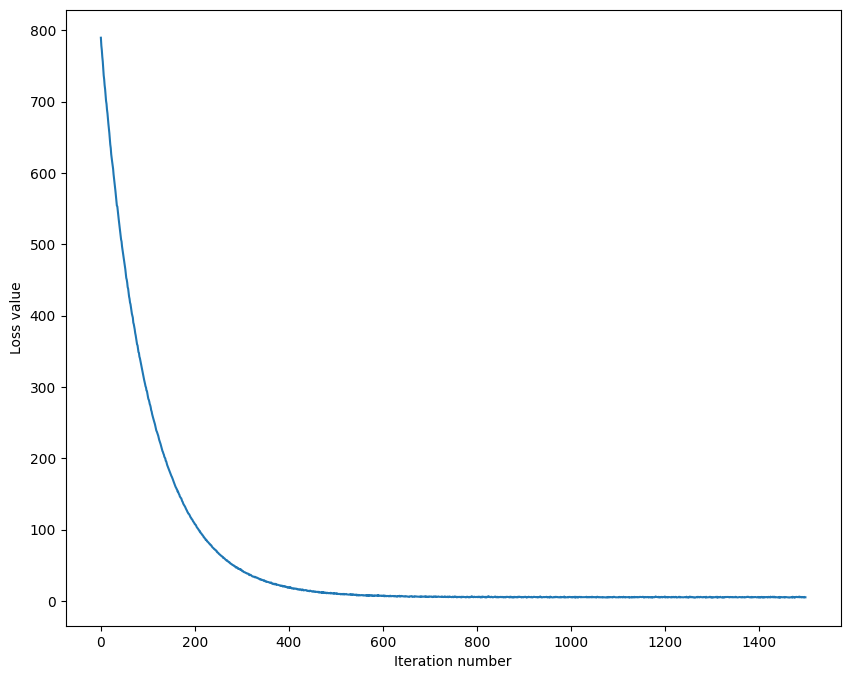

In [24]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
    # 아래는 정답 코드
    # def predict(self, X):
    #     """
    #     Use the trained weights of this linear classifier to predict labels for
    #     data points.

    #     Inputs:
    #     - X: A numpy array of shape (N, D) containing training data; there are N
    #       training samples each of dimension D.

    #     Returns:
    #     - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
    #       array of length N, and each element is an integer giving the predicted
    #       class.
    #     """
    #     y_pred = np.zeros(X.shape[0])
    #     ###########################################################################
    #     # TODO:                                                                   #
    #     # Implement this method. Store the predicted labels in y_pred.            #
    #     ###########################################################################
    #     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #     pass

    #     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    #     return y_pred

In [26]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.374000
validation accuracy: 0.382000


In [29]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates: # 주어진 lr 구간을 돌면서 학습
    for reg in regularization_strengths: # 주어진 reg 구간을 돌며 학습
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 792.209870
iteration 100 / 1000: loss 288.745109
iteration 200 / 1000: loss 107.943359
iteration 300 / 1000: loss 42.927346
iteration 400 / 1000: loss 18.692275
iteration 500 / 1000: loss 10.334704
iteration 600 / 1000: loss 7.304807
iteration 700 / 1000: loss 5.749353
iteration 800 / 1000: loss 5.717539
iteration 900 / 1000: loss 5.264863
iteration 0 / 1000: loss 1557.271707
iteration 100 / 1000: loss 211.168096
iteration 200 / 1000: loss 33.279428
iteration 300 / 1000: loss 9.179418
iteration 400 / 1000: loss 5.957146
iteration 500 / 1000: loss 5.311120
iteration 600 / 1000: loss 5.569797
iteration 700 / 1000: loss 6.022340
iteration 800 / 1000: loss 5.659789
iteration 900 / 1000: loss 5.832185
iteration 0 / 1000: loss 788.141640
iteration 100 / 1000: loss 402247533689333021650934830184827715584.000000
iteration 200 / 1000: loss 66488295750055963865938841164806968350342210048785986550458540811255545856.000000
iteration 300 / 1000: loss 10989982787964425620476

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:97: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:97: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 1000: loss inf
iteration 0 / 1000: loss 1589.671372
iteration 100 / 1000: loss 4353372461329965686196692333474460265878092410982946608013603577683890218473817273900444764064034756682692516244066001747968.000000
iteration 200 / 1000: loss 11241495507536209071786699903579996567291408612803637948285218755515797620562920642727572578524644197008043042446508505230375110295251632433624222102976838029555012737894151158138666753607862081760145067267485708010554451608159441166306501459968.000000
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf


/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:123: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_classifier.py:85: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.369306 val accuracy: 0.379000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.359327 val accuracy: 0.376000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.067837 val accuracy: 0.061000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.379000


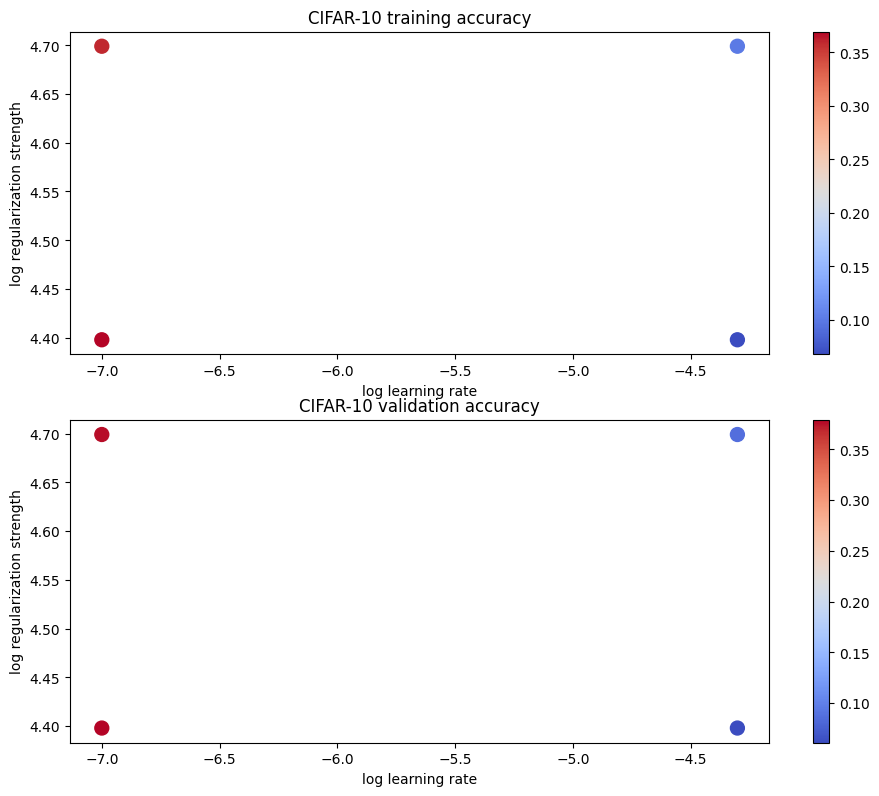

In [30]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [31]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.371000


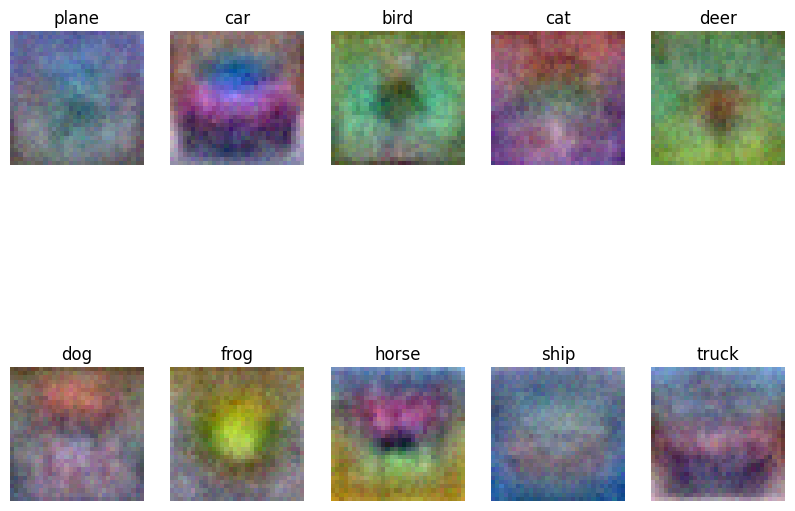

In [32]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$

각각의 클래스들의 이미지는 해당 클래스가 나타내는 객체와 닮아있다. car와 ship의 경우에는 확실히 자동차의 형상과 바다위에 vessel의 형상이 보인다.

이는 svm에서 각 클래스에 대한 점수를 계산하고 이후 가중치를 조정해 나갈때 incorrect_counting을 사용했던 것 덕분에 가능한 일이다.

하나의 클래스 (예를 들어, cat 클래스)에서 잘못 분류된 것들을 모두 카운팅하여 가중치를 정분류된 레이블에 몰아주었다. 이를 통해 해당 이미지로 분류되도록 하는 확률을 높였다. 따라서 위의 결과값또한 정분류된 이미지들의 픽셀값들을 모으게 되고 그렇다면 해당 클래스의 특징들을 잘 대변할 수 있게될 것이다.

